In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [2]:
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')

  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-bm3hlc3y
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-bm3hlc3y
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-py3-none-any.whl size=729978 sha256=d7b73693a1744610d8a43b34b81c2d2e0fe3b962b9d5f48d11718f9131f07b1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnu_takc/wheels/06/13/e0/5bd72c969fe3954ee1561739e5c58e2ddfe5c10fcdffb12faa
Successfully built altair


DataTransformerRegistry.enable('default')

Now that we have done some EDA (exploratory data analysis), we will do some feature engineering using the variables that we looked at in the ETL notebook. We'll start as before but after we try some things out, we will use Apache Beam to run a pipeline

In [3]:
%%bigquery df
SELECT
  pov.Geographic_Area,
  pov.City,
  poverty_rate,
  percent_completed_hs
FROM
  police_brutality.PercentagePeopleBelowPovertyLevel AS pov
JOIN
  police_brutality.PercentOver25CompletedHighSchool AS high
ON
  pov.Geographic_Area=high.Geographic_Area
  AND pov.City=high.City

In [8]:
df.tail()

,Geographic_Area,City,poverty_rate,percent_completed_hs
29324,WY,East Thermopolis town,18.800,88.500
29325,WY,Encampment town,28.800,98.800
29326,WY,Lucerne CDP,0.900,80.400
29327,WY,Moose Wilson Road CDP,1.800,97.300
29328,WY,Riverside town,1.800,100.000


In [30]:
base_sql = """
CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);

WITH stats AS (
    SELECT
      MIN(poverty_rate) AS min_pov,
      IF(MAX(poverty_rate)<60, MAX(poverty_rate), 60) AS max_pov,
      AVG(IF(poverty_rate < 60, poverty_rate, 60)) AS avg_pov,
      STDDEV(IF(poverty_rate <60, poverty_rate, 60)) AS stddev_pov,
      APPROX_QUANTILES(IF(poverty_rate <60, poverty_rate, 60), 100)[OFFSET(1)] AS percentile_1,
      APPROX_QUANTILES(IF(poverty_rate <60, poverty_rate, 60), 100)[OFFSET(99)] AS percentile_99
    FROM
      police_brutality.PercentagePeopleBelowPovertyLevel 
),

scaling AS (
    SELECT
      IF(IFNULL(poverty_rate, -1) < 60, poverty_rate, 60) as poverty_rate,
      IFNULL(Median_Income, -1) as Median_Income,
      SAFE_DIVIDE(2*poverty_rate - 60 - min_pov, 60 - min_pov) AS minmax_scaled,
      CLIP( (poverty_rate - avg_pov)/(avg_pov/2.0), -1, 1 ) AS clipped,
      SAFE_DIVIDE(poverty_rate - avg_pov, stddev_pov) AS zscore,
      CLIP(poverty_rate, percentile_1, percentile_99) AS winsorized_1_99,
      SAFE_DIVIDE(2*CLIP(poverty_rate, percentile_1, percentile_99) - percentile_1 - percentile_99, percentile_99 - percentile_1) AS winsorized_scaled
    FROM
      police_brutality.combined_wo_killings, stats
)
"""

def scaled_stats(base_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(Median_Income) AS avg_inc,
   COUNT(1) AS num_cities
FROM
   scaling
GROUP BY {0}
ORDER BY {0}
    """.format(base_col)
    from google.cloud import bigquery
    return bigquery.Client().query(sql).to_dataframe()

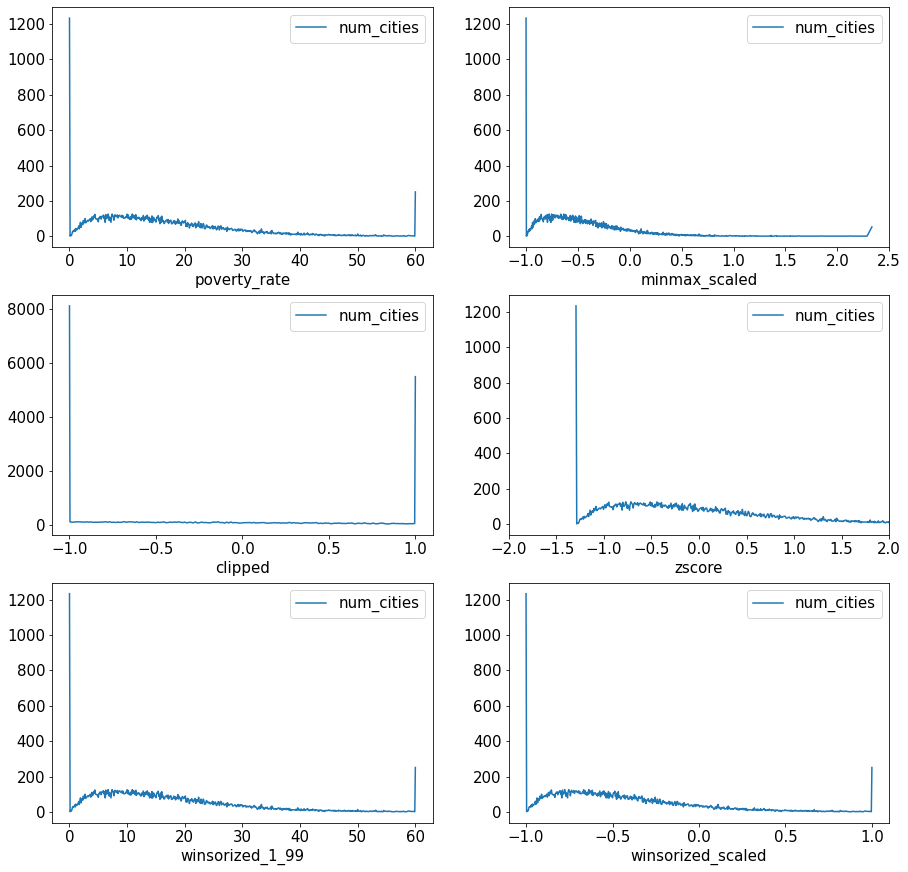

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
scaled_stats('poverty_rate').plot(x='poverty_rate', y='num_cities', ax=axs[0, 0]);
scaled_stats('minmax_scaled').plot(x='minmax_scaled', y='num_cities', ax=axs[0, 1]);
scaled_stats('clipped').plot(x='clipped', y='num_cities', ax=axs[1, 0]);
scaled_stats('zscore').plot(x='zscore', y='num_cities', ax=axs[1, 1], xlim=[-2, 2]);
scaled_stats('winsorized_1_99').plot(x='winsorized_1_99', y='num_cities', ax=axs[2, 0]);
scaled_stats('winsorized_scaled').plot(x='winsorized_scaled', y='num_cities', ax=axs[2, 1]);
fig.savefig('scaling.png')
#plt.close(fig)
plt.show()

Here we are scaling the povery rate, where we note that above 60% there is not enough data and thus we constrain the povery rate to not go above that.  The question then is, which scaling should we choose? Generally, when the curve looks like a normal or uniform distribution we have a good scaling.  In the case of neural networks, we should ensure that all features are between $-1$ and $1$, which is the case for the minimax, winsorized and the clipped scales but not for the zscore and wisorized-1_99 scales. The big problem we should notice here is that there's not a lot of data for each poverty level; Hence I will use bucketing. 

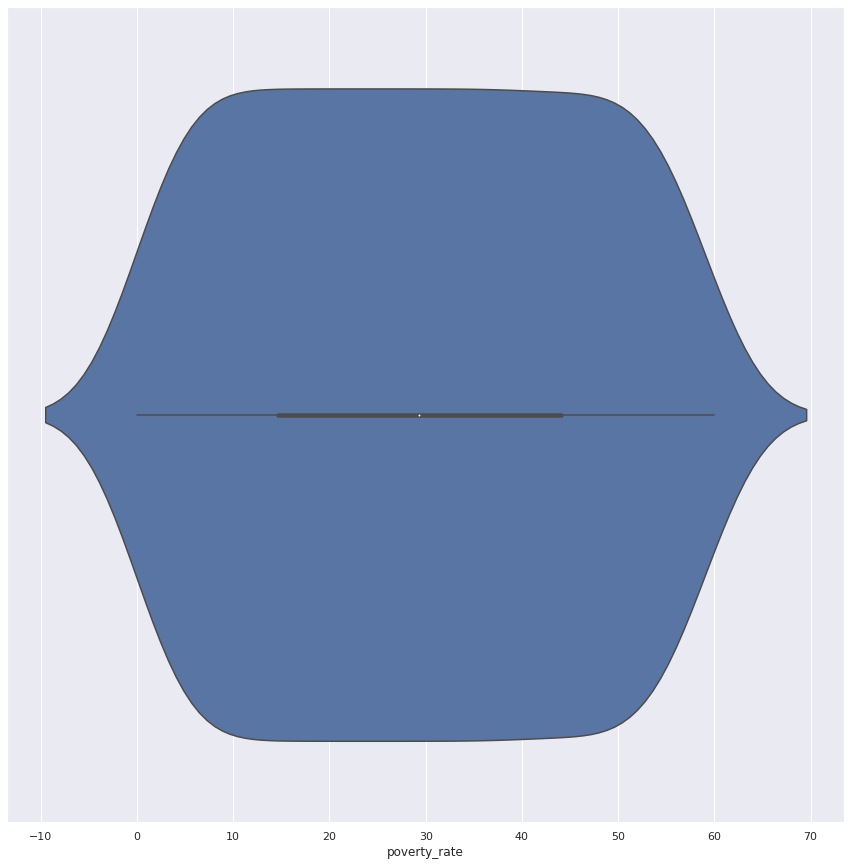

In [53]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=scaled_stats('poverty_rate'), x='poverty_rate', inner='box', orient='h')

The unscaled poverty rate looks quite symmetric now, after I clipped it at 60%.   Nevertheless, we will use bucketing with learned threasholds:

In [15]:
%%bigquery buckets
WITH
  percentile AS (
  SELECT
    APPROX_QUANTILES( share_hispanic, 30) AS hispanic,
    APPROX_QUANTILES( share_native_american, 30) AS native_american,
    APPROX_QUANTILES( share_asian, 30) AS asian,
    APPROX_QUANTILES(share_black, 30) AS black,
    APPROX_QUANTILES(share_white, 30) AS white,
    APPROX_QUANTILES(percent_completed_hs, 30) AS hs,
    APPROX_QUANTILES(Median_Income, 30) AS income,
    APPROX_QUANTILES(poverty_rate, 30) AS poverty
  FROM
    police_brutality.combined_wo_killings ),
  bucketized AS (
  SELECT
    state,
    City AS city,
    CAST(REPLACE(ML.BUCKETIZE( poverty_rate,
          poverty), 'bin_', '') AS int64) AS poverty,
    CAST(REPLACE(ML.BUCKETIZE( percent_completed_hs,
          hs), 'bin_', '') AS int64) AS completed_hs,
    CAST(REPLACE(ML.BUCKETIZE( Median_Income,
          income), 'bin_', '') AS int64) AS income,
    CAST(REPLACE(ML.BUCKETIZE( share_white,
          white), 'bin_', '') AS int64) AS white,
    CAST(REPLACE(ML.BUCKETIZE( share_black,
          black), 'bin_', '') AS int64) AS black,
    CAST(REPLACE(ML.BUCKETIZE( share_hispanic,
          hispanic), 'bin_', '') AS int64) AS hispanic,
    CAST(REPLACE(ML.BUCKETIZE( share_asian,
          asian ), 'bin_', '') AS int64) AS asian,
    CAST(REPLACE(ML.BUCKETIZE( share_native_american,
          native_american ), 'bin_', '') AS int64) AS native_american,
  FROM
    police_brutality.combined_wo_killings,
    percentile)
SELECT
  state, city,  
  ifnull(poverty, -1) as povery,
  ifnull(completed_hs, -1) as completed_hs,
  ifnull(income, -1) as income,
  ifnull(white, -1) as white,
  ifnull(black, -1) as black,
  ifnull(hispanic, -1) as hispanic,
  ifnull(asian, -1) as asian,
  ifnull(native_american, -1) as native_american,
FROM
  bucketized

In [16]:
buckets.head()

,state,city,povery,completed_hs,income,white,black,hispanic,asian,native_american
0,MN,Welcome city,23,15,11,31,3,15,2,2
1,PA,Walnuttown CDP,21,3,11,31,2,8,2,2
2,IL,Farmersville village,20,27,21,31,2,4,2,2
3,ND,Strasburg city,19,4,2,31,2,2,2,2
4,MN,Ivanhoe city,16,14,10,31,2,3,2,2


In [20]:
buckets.describe()

,povery,completed_hs,income,white,black,hispanic,asian,native_american
count,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000,28018.000
mean,15.462,16.440,16.027,16.583,10.701,14.695,7.770,6.826
std,8.672,8.765,9.005,8.759,7.264,8.459,5.525,4.674
min,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
25%,8.000,9.000,8.000,9.000,4.000,7.000,2.000,3.000
50%,15.000,16.000,16.000,17.000,10.000,15.000,6.000,5.000
75%,23.000,24.000,24.000,24.000,17.000,22.000,12.000,10.000
max,31.000,31.000,32.000,32.000,25.000,30.000,20.000,18.000


In [24]:
np.array(sorted(buckets['income'].unique()))

array([-1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

We give a special treatment to missing values and the assumptions will be important; I will give them their own category of -1 as missing values are assumed not to arise randomly. 

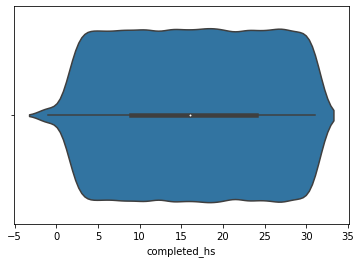

In [19]:
ax = sns.violinplot(data=buckets, x='completed_hs', inner='box', orient='h')

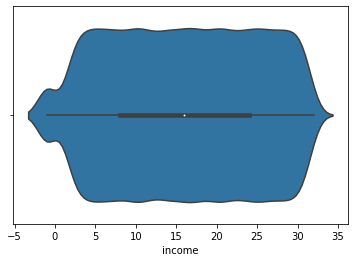

In [21]:
ax = sns.violinplot(data=buckets, x='income', inner='box', orient='h')

Now we can see very balanced features with $-1$ outliers for the missing value category. Now we want to look at correlations of these features:

In [35]:
base_sql = """
WITH
  percentile AS (
  SELECT
    APPROX_QUANTILES( share_hispanic, 30) AS hispanic,
    APPROX_QUANTILES( share_native_american, 30) AS native_american,
    APPROX_QUANTILES( share_asian, 30) AS asian,
    APPROX_QUANTILES(share_black, 30) AS black,
    APPROX_QUANTILES(share_white, 30) AS white,
    APPROX_QUANTILES(percent_completed_hs, 30) AS hs,
    APPROX_QUANTILES(Median_Income, 30) AS income,
    APPROX_QUANTILES(poverty_rate, 30) AS poverty
  FROM
    police_brutality.combined_wo_killings ),
  bucketized AS (
  SELECT
    state,
    City AS city,
    CAST(REPLACE(ML.BUCKETIZE( poverty_rate,
          poverty), 'bin_', '') AS int64) AS poverty,
    CAST(REPLACE(ML.BUCKETIZE( percent_completed_hs,
          hs), 'bin_', '') AS int64) AS completed_hs,
    CAST(REPLACE(ML.BUCKETIZE( Median_Income,
          income), 'bin_', '') AS int64) AS income,
    CAST(REPLACE(ML.BUCKETIZE( share_white,
          white), 'bin_', '') AS int64) AS white,
    CAST(REPLACE(ML.BUCKETIZE( share_black,
          black), 'bin_', '') AS int64) AS black,
    CAST(REPLACE(ML.BUCKETIZE( share_hispanic,
          hispanic), 'bin_', '') AS int64) AS hispanic,
    CAST(REPLACE(ML.BUCKETIZE( share_asian,
          asian ), 'bin_', '') AS int64) AS asian,
    CAST(REPLACE(ML.BUCKETIZE( share_native_american,
          native_american ), 'bin_', '') AS int64) AS native_american,
  FROM
    police_brutality.combined_wo_killings,
    percentile),
  features AS (
  SELECT
    state, city,  
    ifnull(poverty, -1) as poverty,
    ifnull(completed_hs, -1) as completed_hs,
    ifnull(income, -1) as income,
    ifnull(white, -1) as white,
    ifnull(black, -1) as black,
    ifnull(hispanic, -1) as hispanic,
    ifnull(asian, -1) as asian,
    ifnull(native_american, -1) as native_american,
  FROM
    bucketized)
"""

def corr_stats(base_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(completed_hs) AS avg_hs,
  STDDEV(completed_hs) AS std_hs,
  AVG(white) AS avg_white,
  STDDEV(white) as std_white,
  AVG(black) AS avg_black,
  STDDEV(black) as std_black,
  AVG(hispanic) AS avg_hispanic,
  STDDEV(hispanic) as std_hispanic,
  AVG(asian) AS avg_asian,
  STDDEV(asian) as std_asian,
  AVG(native_american) AS avg_native_american,
  STDDEV(native_american) as std_native_american,
FROM
  features
GROUP BY {0}
ORDER BY {0}
    """.format(base_col)
    from google.cloud import bigquery
    return bigquery.Client().query(sql).to_dataframe()

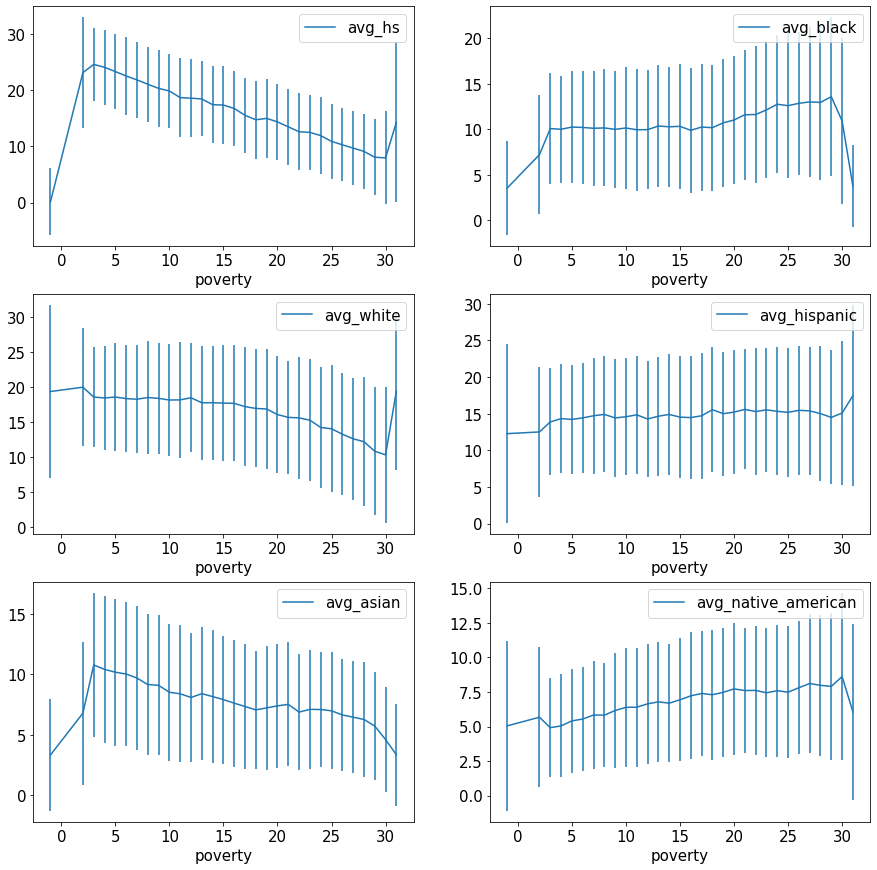

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_hs', yerr='std_hs', ax=axs[0, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_black', yerr='std_black', ax=axs[0, 1]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_white', yerr='std_white', ax=axs[1, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_hispanic', yerr='std_hispanic', ax=axs[1, 1]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_asian', yerr='std_asian', ax=axs[2, 0]);
corr_stats('poverty').plot(kind='line', x='poverty', y='avg_native_american', yerr='std_native_american', ax=axs[2, 1]);
fig.savefig('racePoverty.png')
#plt.close(fig)
plt.show()

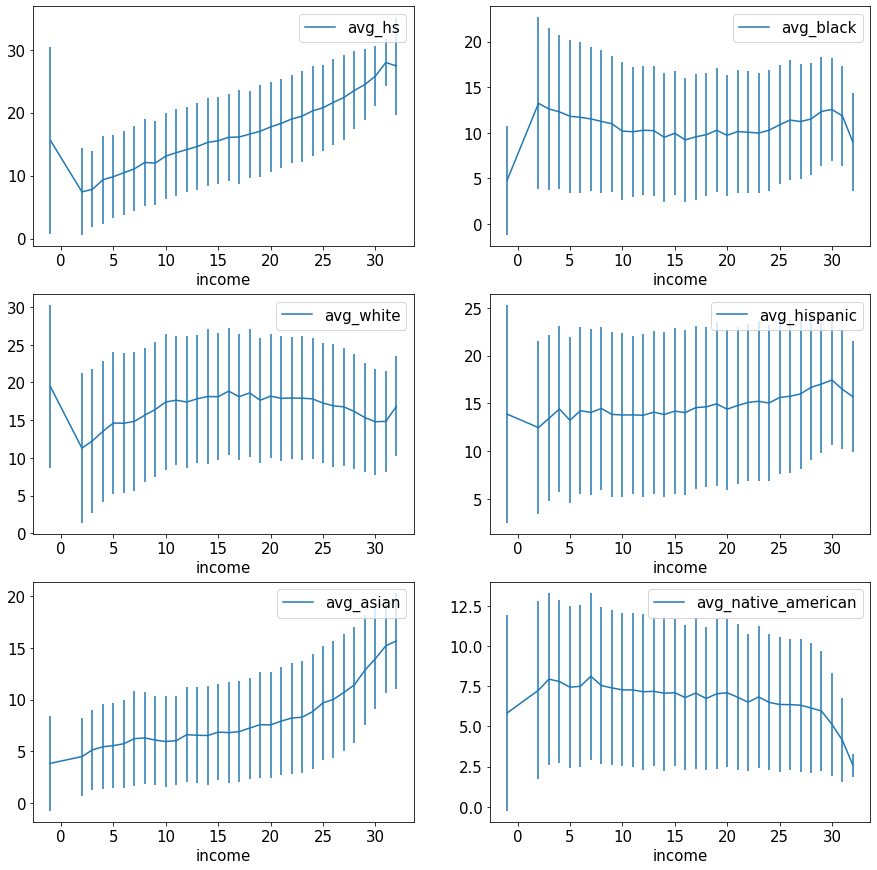

In [36]:
#import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
corr_stats('income').plot(kind='line', x='income', y='avg_hs', yerr='std_hs', ax=axs[0, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_black', yerr='std_black', ax=axs[0, 1]);
corr_stats('income').plot(kind='line', x='income', y='avg_white', yerr='std_white', ax=axs[1, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_hispanic', yerr='std_hispanic', ax=axs[1, 1]);
corr_stats('income').plot(kind='line', x='income', y='avg_asian', yerr='std_asian', ax=axs[2, 0]);
corr_stats('income').plot(kind='line', x='income', y='avg_native_american', yerr='std_native_american', ax=axs[2, 1]);
fig.savefig('raceIncome.png')
#plt.close(fig)
plt.show()

Of course, there are many more correlation plots of this kind that we could plot. While ther are some obvious trends, we can see that the standard deviations are large.  I will include some regional varables, such as if a state and thus a city is in the South or in the North-east etc as well as some interaction features.  Keep in mind that these are all just city and state level features and they don't have a time dimension; later, when we look at the police shootings data, from which we will use features and from which we will derive our label (how many police shootings there will be in a given month) we will work with time varying features, which require a whole other set of considerations. I will also minimax scale these features so that they are all between $-1$ and $1$. Throughout I will keep the base_query and use that as a starting point.  

In [42]:
%%bigquery regions_names
SELECT
  DISTINCT region_id,
  region_description,
  states
FROM
  bigquery-public-data.covid19_geotab_mobility_impact_eu.lookup_region
WHERE
  states IS NOT NULL

In [43]:
regions_names

,region_id,region_description,states
0,1,US 1: New England,Connecticut;Maine;Massachusetts;New Hampshire;...
1,2,US 2: NY/NJ,New Jersey;New York;Puerto Rico;US Virgin Islands
2,3,US 3: Mid-Atlantic,Delaware;District of Columbia;Maryland;Pennsyl...
3,4,US 4: South,Alabama;Florida;Georgia;Kentucky;Mississippi;N...
4,5,US 5: Midwest,Illinois;Indiana;Michigan;Minnesota;Ohio;Wisco...
5,6,US 6: Southwest,Arkansas;Louisiana;New Mexico;Oklahoma;Texas
6,7,US 7: Central,Iowa;Kansas;Missouri;Nebraska
7,8,US 8: Rocky Mountain,Colorado;Montana;North Dakota;South Dakota;Uta...
8,9,US 9: West,Arizona;California;Hawaii;Nevada;American Samo...
9,10,US 10: Northwest + AK,Alaska;Idaho;Oregon;Washington


since we don't need the names of hte regions, we only need the region codes, and since the states that belong to the regions aren't abreviated and in a clumsy shape here, we can get the regions from a more convenient source:

In [46]:
%%bigquery regions
SELECT
  DISTINCT region_code as region, state_abbreviation as state, state_name
FROM 
bigquery-public-data.utility_us.us_states_area 
  

In [51]:
regions[regions['region']=='1'] #we can see that the regions are not the same as those in the earlier table

,region,state,state_name
5,1,RI,Rhode Island
6,1,NH,New Hampshire
7,1,VT,Vermont
8,1,CT,Connecticut
9,1,ME,Maine
10,1,MA,Massachusetts
11,1,NJ,New Jersey
12,1,PA,Pennsylvania
13,1,NY,New York


There is a choice as to how we want to partition the US states into regions and this second way to do it is more compelling to me than the first way to partition the states as they seem more natural upon inspection. Another option is to create an embedding space for states, based on what other states are adjacent to each state and this will be my choice, rather than, say one-hot encode each state and then add a one-hot encoded region. 

In [58]:
%%bigquery state_adjacency
SELECT
  state,
  state_fips_code as state_code,
  fips as neighbors
FROM
  `bigquery-public-data.geo_us_boundaries.adjacent_states`,
  UNNEST( neighbors_fips_code ) AS fips


In [59]:
state_adjacency.head()

,state,state_code,neighbors
0,AL,01,12
1,AL,01,13
2,AL,01,28
3,AL,01,47
4,AR,05,47


In [61]:
state_adjacency[state_adjacency['state_code']=='12']

,state,state_code,neighbors
33,FL,12,01
34,FL,12,13


In [62]:
state_adjacency[state_adjacency['state_code']=='13']

,state,state_code,neighbors
35,GA,13,47
36,GA,13,12
37,GA,13,01
38,GA,13,45
39,GA,13,37


what we need, however, is not an adjacency list, but rather and adjacency matrix with columms and rows being the states where there is a 1 whenever two states are next to each other and 0 otherwise. This creates an embedding so that similarly located states are similar to each other in various distance measures. While this could in this case be done using pandas, because there are only 56 states, I will use Apache Beam to do this because this is scalable and because I will in the end use the queries (using BigQuery) as well as Apache Beam to create all of the features in one big pipeline.  Note that so far all of the calculations were done using BigQuery, except for the visualization.  